In [1]:
import os
from google.colab import drive 
drive.mount('/content/drive')

work_dir = '/content/drive/My Drive/object_detection_practicum_oct27'
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
%pwd 
%ls

Mounted at /content/drive
checkmodel.h5    dataset_object.zip     imgs_box_backup_10000.npy
dataset_object/  imgs_backup_10000.npy  object_detection_model_simple.h5


In [2]:
!rm -rf dataset_object
!rm -rf dataset_object*zip
#!wget https://cs.slu.edu/~hou/5750/data/object_detection/dataset_object.zip --no-check-certificate
!wget https://cs.slu.edu/~hou/5750/homework/hw07/dataset_object.zip --no-check-certificate
!unzip  dataset_object.zip


--2020-11-10 05:04:02--  https://cs.slu.edu/~hou/5750/homework/hw07/dataset_object.zip
Resolving cs.slu.edu (cs.slu.edu)... 165.134.107.79
Connecting to cs.slu.edu (cs.slu.edu)|165.134.107.79|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 103318 (101K) [application/zip]
Saving to: ‘dataset_object.zip’

dataset_object.zip  100%[===================>] 100.90K   285KB/s    in 0.4s    

2020-11-10 05:04:03 (285 KB/s) - ‘dataset_object.zip’ saved [103318/103318]

Archive:  dataset_object.zip
   creating: dataset_object/
  inflating: dataset_object/StopSign_1.jpg  
  inflating: dataset_object/car_1.jpg  
   creating: dataset_object/test_data/
  inflating: dataset_object/test_data/test_1.xml  
  inflating: dataset_object/test_data/test_6.jpg  
  inflating: dataset_object/test_data/test_5.jpg  
  inflating: dataset_object/test_data/test_4.jpg  
  inflating: dataset_object/test_data/test_3.jpg  
  inflating: dataset_ob

In [3]:
# check the files in current folder
%ls dataset_object/

car_1.jpg  StopSign_1.jpg  test_data/


In [4]:
%ls

checkmodel.h5    dataset_object.zip     imgs_box_backup_10000.npy
dataset_object/  imgs_backup_10000.npy  object_detection_model_simple.h5


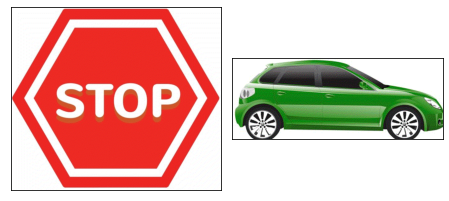

In [5]:
from matplotlib import pyplot as plt
import glob

import base64
from PIL import Image
import numpy as np

fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

## plot first image
img_path ='dataset_object/StopSign_1.jpg'
ax = fig.add_subplot(1,2,1, xticks=[], yticks=[])
# PIL image, convert to mode "P" to translates pixels through the palette and range of pixels still in [0,255] with color image 
img = Image.open(img_path).convert("P") 
ax.imshow(img)
img.close()

## plot second image
img_path ='dataset_object/car_1.jpg'
ax = fig.add_subplot(1,2,2, xticks=[], yticks=[])
img = Image.open(img_path).convert("P") 
ax.imshow(img)
img.close()


In [6]:
import numpy as np
import random

def create_inhouse_dataset(num_imgs, img_size = 128):
    ### num_imgs: number of images to create (Note: increase this number may improve performance)
    ### img_size: set image size to 128*128 (Note: can also practice different size)


    ### size of bounding box for object
    stop_size_min = 30
    stop_size_max = 50

    ### number of interested object, here we set 1 for simplicity
    num_objects = 1

    ### create arrays to store images (X)
    imgs = np.empty((num_imgs, img_size, img_size))  # set image background to 255 (white)
    imgs.fill(255)

    ### create arrays to store boundary boxes (Y)
    bboxes = np.zeros((num_imgs, num_objects, 4))

    ### Start create custom images
    for i_img in range(num_imgs):
        
        boxes_cur = [] # check overlap
        for i_object in range(num_objects):
          
          ### sample the width and height for object
          width, height = np.random.randint(stop_size_min, stop_size_max, size=2)
          
          ### sample location to put object in image
          row = np.random.randint(0, img_size - height)
          column = np.random.randint(0, img_size - width)


          img_path ='dataset_object/StopSign_1.jpg'
          img = Image.open(img_path) # RGB mode with three channel
          # PIL image, convert to mode "P" to translates pixels through the palette and range of pixels still in [0,255] with color image 
          img = img.convert("P")  # convert into one channel
          img = img.resize((width, height)) # resize

          # convert into numpy array
          img_data = np.asarray(img).copy()
          img_data[img_data>=np.quantile(img_data, .6)] = 255 # set background to white
          imgs[i_img, row:row+height, column:column+width] = np.asarray(img_data)  # set local region to this object
          bboxes[i_img, i_object] = [column, row, width, height]
          boxes_cur.append([column, row, width, height]) # store the region that has been embedded.
        

        ### number of non-interested objects (car) to be added
        num_car = np.random.randint(3, 10)
        width,height= 40,20
        for pos in range(0, int(img_size/width)*int(img_size/height)):
              row = int(pos/int(img_size/width))*height
              column = int(pos % int(img_size/width))*width
              ### check if overlaping with any objects
              check_valid = True
              for bbox in boxes_cur:
                  x1, y1, w1, h1 = bbox[0], bbox[1], bbox[2], bbox[3]
                  x2, y2, w2, h2 = column, row, width, height
                  w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
                  h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
                  if w_I > 0 or h_I > 0:  #  overlap
                      check_valid = False
                      break
              if check_valid:
                boxes_cur.append([column, row, width, height])
                img_path ='dataset_object/car_1.jpg'
                img = Image.open(img_path).convert("P") 
                img = img.resize((width, height))
                img_data = np.asarray(img).copy()
                img_data[img_data>np.quantile(img_data, .6)] = 255 # set background to white
                imgs[i_img, row:row+height, column:column+width] = np.asarray(img_data)  # set local region to this object
                if len(boxes_cur)-1<num_car:
                  continue
                else:
                  break
    return imgs, bboxes



**Generate the dataset**

In [7]:
# set to 100 for demo, but high accuracy can be achievied with number set to 50000
num_imgs = 1000

### set image size to 128*128 (Note: can also practice different size)
img_size = 128 

imgs, bboxes = create_inhouse_dataset(num_imgs, img_size = 128) # may take time if num_imgs is set too large
imgs.shape, bboxes.shape

((1000, 128, 128), (1000, 1, 4))

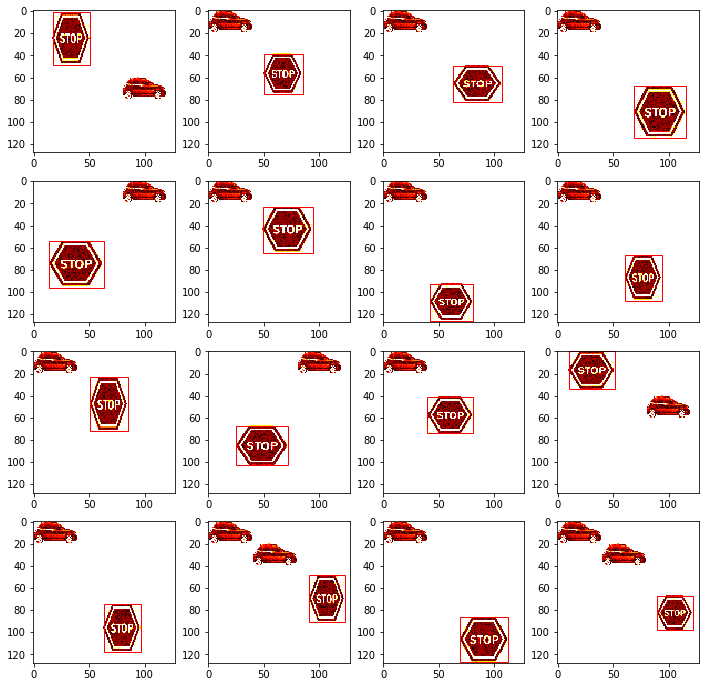

In [8]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.figure(figsize=(12, 12))
for img_idx in range(1,17):
    plt.subplot(4, 4, img_idx)
    img = Image.fromarray(imgs[img_idx])
    plt.imshow(imgs[img_idx], cmap='hot', interpolation='nearest')
    for bbox in bboxes[img_idx]:
        plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [9]:
# save the train data for later use.
save_data = True
if save_data:
  import numpy as np
  np.save('imgs_backup_10000', imgs) 
  np.save('imgs_box_backup_10000', bboxes) 

In [10]:
num_imgs=imgs.shape[0]

X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)

# save the mean and std
train_mean = np.mean(imgs)
train_std = np.std(imgs)

print(X.shape, train_mean, train_std)

(1000, 16384) 237.38188024902342 57.21429867306933


In [11]:
y = bboxes.reshape(num_imgs, -1) / img_size

y.shape, np.mean(y), np.std(y)

print(y)

[[0.625     0.5625    0.2734375 0.359375 ]
 [0.1328125 0.0078125 0.265625  0.375    ]
 [0.390625  0.3046875 0.2734375 0.28125  ]
 ...
 [0.1171875 0.25      0.375     0.2734375]
 [0.2109375 0.546875  0.359375  0.296875 ]
 [0.6796875 0.3359375 0.2734375 0.2578125]]


**Visualize the curated image data and bounding box**

In [12]:
from sklearn.model_selection import ShuffleSplit
split = ShuffleSplit(n_splits=1, test_size=.2, random_state=0)
for train_index, test_index in split.split(X):
    #print("TRAIN:", train_index, "\nTEST:", test_index)
    train_X = X[train_index]
    test_X = X[test_index]
    train_y = y[train_index]
    test_y = y[test_index]
    test_imgs = imgs[test_index]
    test_bboxes = bboxes[test_index]

In [13]:
train_X = train_X.reshape(train_X.shape[0],img_size,img_size,1)
print(train_X.shape)

(800, 128, 128, 1)


In [14]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,MaxPooling2D
from keras import regularizers
from keras.layers import Flatten,BatchNormalization,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.0001),
      ModelCheckpoint('./checkmodel.h5', monitor='val_loss', save_best_only=True, mode='min')
]


model = Sequential() # create Sequential model
model.add(Conv2D(filters = 9, kernel_size=(3,3), input_shape=(128,128,1), padding='same', activation = 'relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 9, kernel_size=(3,3), padding='same')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 9, kernel_size=(3,3), padding='same')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(4, activation = 'sigmoid')) 
model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ['accuracy'])
train_history = model.fit(train_X,train_y, validation_split=0.1,batch_size=50, epochs = 50,callbacks = keras_callbacks)

Epoch 1/50
15/15 [==============================] - 1s 72ms/step - loss: 0.0518 - accuracy: 0.5764 - val_loss: 0.0227 - val_accuracy: 0.6375
Epoch 2/50
15/15 [==============================] - 0s 16ms/step - loss: 0.0142 - accuracy: 0.7264 - val_loss: 0.0124 - val_accuracy: 0.6750
Epoch 3/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0047 - accuracy: 0.8028 - val_loss: 0.0111 - val_accuracy: 0.7125
Epoch 4/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0025 - accuracy: 0.8153 - val_loss: 0.0101 - val_accuracy: 0.8250
Epoch 5/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0017 - accuracy: 0.8181 - val_loss: 0.0092 - val_accuracy: 0.7750
Epoch 6/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0014 - accuracy: 0.8556 - val_loss: 0.0092 - val_accuracy: 0.7875
Epoch 7/50
15/15 [==============================] - 0s 11ms/step - loss: 0.0011 - accuracy: 0.8639 - val_loss: 0.0093 - val_accuracy: 0.7625
Epoch 8/50
15

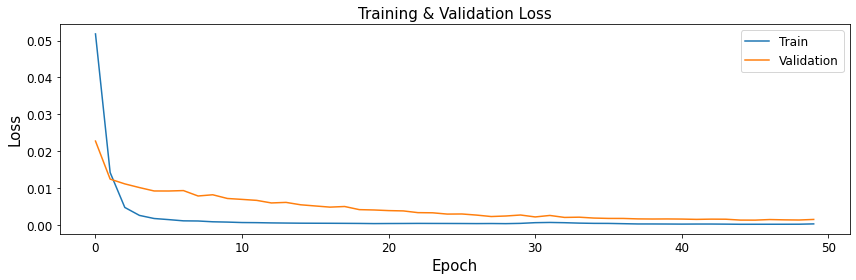

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(1,1,1)
# Plot training & validation loss values
plt.plot(train_history.history['loss'], label='Train')
plt.plot(train_history.history['val_loss'], label='Validation')
plt.title('Training & Validation Loss', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

**We can also save the trained model to disk for later use, which can be done using following codes.**

In [16]:
test_X = test_X.reshape(test_X.shape[0],img_size,img_size,1)
print(test_X.shape)

(200, 128, 128, 1)


In [17]:
from keras.models import load_model

# save the model to disk
model.save("object_detection_model_simple.h5")

# load the model from disk
model_loaded = load_model("object_detection_model_simple.h5")


# Question: if we continue to train the data using the loaded model 'model_loaded', what will happen? Any difference?

**Predict bounding boxes on the test images**

In [18]:
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), 1, -1)
pred_bboxes.shape

(200, 1, 4)

**Define the calculation of IoU score**

In [19]:
### Define the calculation of IoU score
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

In [27]:
# training data
model.evaluate(train_X,train_y)

# testing data
model.evaluate(test_X,test_y)

7/7 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.8500


[0.0011786395916715264, 0.8500000238418579]

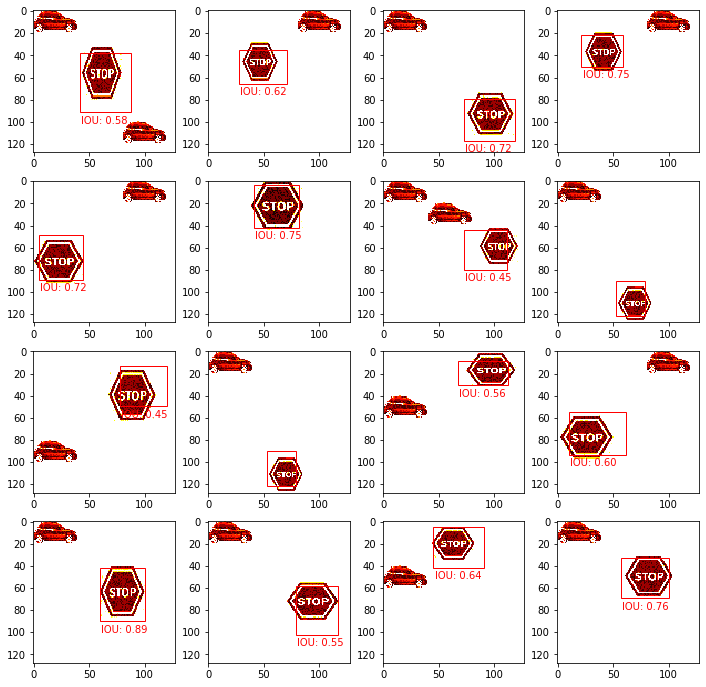

In [20]:

plt.figure(figsize=(12, 12))
for i_subplot in range(1, 17):
    plt.subplot(4, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i], cmap='hot', interpolation='nearest')
    
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0]+1, pred_bbox[1]+pred_bbox[3]+10), color='r')


**Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset.**

In [21]:
# Predict bounding boxes on the test images.
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
print("Testing IOU: ",mean_IOU)

Testing IOU:  0.722453596790212


**Predict bounding boxes on the test images**

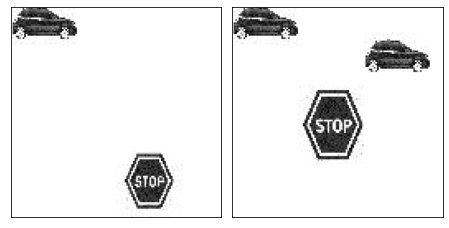

In [24]:
from matplotlib import pyplot as plt
import glob

import base64
from PIL import Image
import numpy as np

fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

## plot first image
img_path ='dataset_object/test_data/test_1.jpg'
ax = fig.add_subplot(1,2,1, xticks=[], yticks=[])
# PIL image, convert to mode "P" to translates pixels through the palette and range of pixels still in [0,255] with color image 
img = Image.open(img_path).convert("P") 
ax.imshow(img)
img.close()

## plot second image
img_path ='dataset_object/test_data/test_2.jpg'
ax = fig.add_subplot(1,2,2, xticks=[], yticks=[])
img = Image.open(img_path).convert("P") 
ax.imshow(img)
img.close()

In [25]:
train_mean = np.mean(imgs)
train_std = np.std(imgs)

print(train_mean, train_std)


237.38188024902342 57.21429867306933


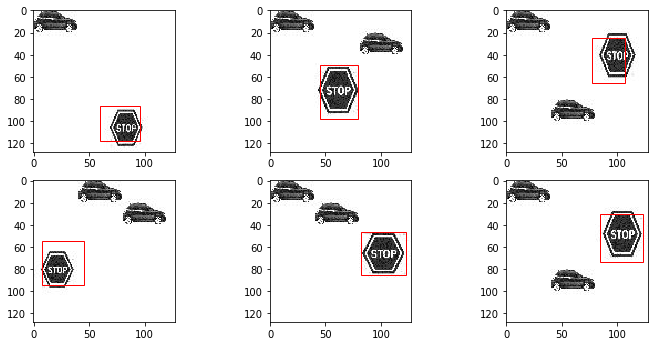

In [26]:
### Loading new test data
img_size = 128 
plt.figure(figsize=(12, 12))
idx=1
summed_IOU = 0
for test_img in sorted(glob.glob('dataset_object/test_data/*.jpg')):
  img = Image.open(test_img) # RGB mode with three channel
  img = img.convert("P")  # convert into one channel
  img = img.resize((img_size, img_size)) # resize
  # convert into numpy array
  img_data = np.asarray(img).copy()
  img_data[img_data>=np.quantile(img_data,0.8)] = 255 # set background to white
  
  ### normalize test data using mean & std from training
  img_data = (img_data.reshape(1, img_data.shape[0]*img_data.shape[1]) - train_mean) / train_std

  img_data = img_data.reshape(1,img_size,img_size,1)

  ### Make a prediction 
  pred_bbox = model.predict(img_data)[0]
  pred_bbox = pred_bbox*img_size
  
  # Show a few images and predicted bounding boxes from the test dataset. 
  plt.subplot(4, 3, idx)
  idx +=1
  plt.imshow(img, cmap='hot', interpolation='nearest')
  plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))


**Homework 07 for Practicum**

Please practice the following questions to better undertand this practicum for the object detection problem. 

1. Label all 6 test images saved in 'dataset_object/test_data'. 


2. Increase the number of images in training data, to see if the performance of object detection (average IoU score) can be improved.

3. Change the neural network architecture to convolutional neural network architecture


**Requirement:**

Submit the notebook 
Submit a summary from this practicum to Canvas: Homework 07
Due: Nov 2, Monday, 23:59pm